<a href="https://colab.research.google.com/github/TAUforPython/BioMedAI/blob/main/NN%20CNN%20LSTM%20EEG%20DF%20MI%20Class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.physionet.org/pn4/eegmmidb/

2-class: MI trials of opening and closing either the right or the left fist. Due to some variability in the number of trials per subject, a subset of 105 subjects and 42 trials per subject were selected (21 for each side), although most subjects performed more than 42 trials.

https://www.sciencedirect.com/science/article/pii/S0957417418305359?via%3Dihub

##CNN-2D и CNN-2D + LSTM + STFT + CWT

In [1]:
!pip install pywavelets --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 27.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from scipy.signal import spectrogram
import pywt
import cv2
from sklearn.metrics import cohen_kappa_score, confusion_matrix
from keras.models import Sequential
from keras.layers import (Conv2D, MaxPool2D, Flatten, Dense, Dropout,
                          TimeDistributed, LSTM)
from keras.optimizers import Adam
from keras import backend as K

In [3]:
# download dataset
x_train = pd.read_csv("https://github.com/TAUforPython/BioMedAI/blob/main/test_datasets/MI-EEG-B9T.csv?raw=true",
                      header=None)
x_test = pd.read_csv("https://github.com/TAUforPython/BioMedAI/blob/main/test_datasets/MI-EEG-B9E.csv?raw=true",
                     header=None)
y_train = pd.read_csv("https://github.com/TAUforPython/BioMedAI/blob/main/test_datasets/2class_MI_EEG_train_9.csv?raw=true",
                      header=None)
y_test = pd.read_csv("https://github.com/TAUforPython/BioMedAI/blob/main/test_datasets/2class_MI_EEG_test_9.csv?raw=true",
                     header=None)

In [4]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(400, 3000)
(320, 3000)
(400, 1)
(320, 1)


In [5]:
n_samples_train = len(y_train)
n_samples_test = len(y_test)

print("n_samples_train:", n_samples_train)
print("n_samples_test :", n_samples_test)

n_samples_train: 400
n_samples_test : 320


In [6]:
# count classes
n_classes = len(np.unique(y_test))

print("n_classes:", n_classes)

n_classes: 2


In [7]:
# calculate STFT

def spectrogram_vertical(data, fs, alto, ancho, n_canales, pts_sig,
                                 pts_superpuestos):
  #fs = fs #frecuencia de muestreo
  datesets = np.zeros((data.shape[0],alto, ancho))

  # crear matriz 2D donde se guardara cada imagen del STFT
  temporal = np.zeros((alto, ancho))

  for i in range(data.shape[0]): # n muestras
    for j in range(n_canales): # n canales

      sig = data.iloc[i, j*pts_sig:(j+1)*pts_sig]

      f, t, Sxx = spectrogram(sig, fs=fs, window='hann', nperseg=fs,
                              noverlap=pts_superpuestos, nfft=fs*2,
                              scaling='spectrum')

      # concatenacion vertical chanels
      temporal[j*45:(j+1)*45, :] = Sxx[16:61, :]

    datesets[i] = temporal
    if i % 100 == 0:
      print(i)
  return datesets

In [8]:
# calculate scalogram CWT

def scalogram_vertical(data, fs, alto, ancho, n_canales, pts_sig):
  dim = (int(np.floor(ancho/2)), int(np.floor(alto/2))) # ancho, alto

  # Wavelet Morlet 3-3
  # frequency 8 - 30 Hz
  scales = pywt.scale2frequency('cmor3-3', np.arange(8,30.5,0.5)) / (1/fs)

  datesets = np.zeros((data.shape[0], int(np.floor(alto/2)),
                    int(np.floor(ancho/2))))

  temporal = np.zeros((alto, ancho))

  for i in range(data.shape[0]):
    for j in range(n_canales):

      sig = data.iloc[i, j*pts_sig:(j+1)*pts_sig]

      coef, freqs = pywt.cwt(sig, scales, 'cmor3-3',
                             sampling_period = (1 / fs))

      temporal[j*45:(j+1)*45, :] = abs(coef)

    resized = cv2.resize(temporal, dim, interpolation=cv2.INTER_AREA)
    datesets[i] = resized
    if i % 100 == 0:
      print(i)
  return datesets

In [9]:
initial = time.time()

# STFT
x_train = spectrogram_vertical(x_train, 250, 135, 31, 3, 1000, 225)
x_test = spectrogram_vertical(x_test, 250, 135, 31, 3, 1000, 225)

# CWT
#x_train = scalogram_vertical(x_train, 250, 135, 1000, 3, 1000)
#x_test = scalogram_vertical(x_test, 250, 135, 1000, 3, 1000)

fin = time.time()
print("time_elapsed:", fin - initial)

0
100
200
300
0
100
200
300
time_elapsed: 1.3145318031311035


In [10]:
print(x_train.shape)
print(x_test.shape)

(400, 135, 31)
(320, 135, 31)


In [11]:
x = np.ceil(np.max(x_train))

In [12]:
# convert to float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= x
x_test /= x

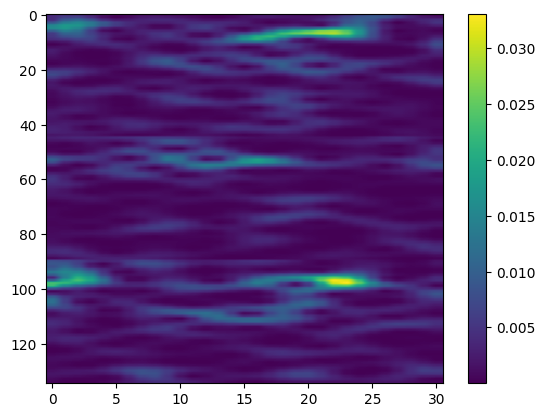

In [13]:
plt.figure()
plt.imshow(x_train[1],  aspect='auto')
plt.colorbar()
plt.show()

In [14]:
#  reshape a 4D (for CNN-2D)
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))

# convert  3D to 5D (CNN-2D + LSTM)
#x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1], x_train.shape[2], 1))
#x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1], x_test.shape[2], 1))

print(x_train.shape)
print(x_test.shape)

(400, 135, 31, 1)
(320, 135, 31, 1)


In [15]:
# crear red neuronal CNN-2D

def CNN_2D(num_filter, size_filter, n_neurons):
  model = Sequential()
  model.add(Conv2D(num_filter, size_filter, activation='relu', padding='same',
                   input_shape=x_train.shape[1:]))
  model.add(MaxPool2D((2,2)))
  model.add(Conv2D(num_filter, size_filter, activation='relu', padding='same'))
  model.add(MaxPool2D((2,2)))
  model.add(Flatten())
  model.add(Dense(n_neurons, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(learning_rate=0.001)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model

In [57]:
# crear red neuronal CNN-2D + LSTM

def CNN_2D_LSTM_TD(num_filter, size_filter, n_neurons, units_LSTM):
  model = Sequential()
  model.add(TimeDistributed(Conv2D(num_filter, size_filter, activation='relu',
                                   padding='same'),
                            input_shape=x_train.shape[1:]))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Conv2D(num_filter, size_filter, activation='relu',
                                   padding='same')))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(units_LSTM, activation='tanh', dropout=0.5))
  model.add(Dense(n_neurons, activation='relu'))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(learning_rate=1e-3)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model

In [16]:
initial = time.time()
array_loss = []
array_acc = []
array_kappa = []
for i in range(5):
  print("Iteration:", i+1)


  model = CNN_2D(4, (3,3), 32)
  #model = CNN_2D_LSTM_TD(4, (3,3), 32, 4)

 # history = model.fit(x_train, y_train, epochs=40, batch_size=36,
 #                     validation_data=(x_test, y_test), verbose=0)

  history = model.fit(x_train, y_train, epochs=70, batch_size=36,
                       validation_split = 0.1, verbose=0)

  test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

  array_loss.append(test_loss)
  print("loss: ", test_loss)
  array_acc.append(test_acc)
  print("accuracy: ", test_acc)

Iteration: 1


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


loss:  0.4759801924228668
accuracy:  0.7906249761581421
Iteration: 2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


loss:  0.5286314487457275
accuracy:  0.8187500238418579
Iteration: 3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


loss:  0.572801411151886
accuracy:  0.78125
Iteration: 4


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


loss:  0.44937771558761597
accuracy:  0.8125
Iteration: 5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


loss:  0.5150427222251892
accuracy:  0.762499988079071


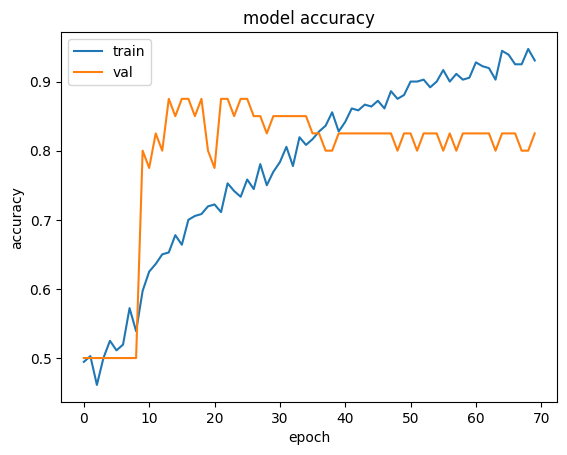

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [18]:
probabilidades = model.predict(x_test)

y_pred = np.argmax(probabilidades, 1)

  # calculate kappa cohen
kappa = cohen_kappa_score(y_test, y_pred)
array_kappa.append(kappa)
print("kappa: ", kappa)
matriz_confusion = confusion_matrix(y_test, y_pred)
print("confusion matrix:\n", matriz_confusion)


#Интерпретация
#(\kappa = 1): Полное согласие, модель идеально предсказывает все классы.
#(\kappa = 0): Согласие на уровне случайного угадывания.
#(\kappa < 0): Согласие хуже, чем случайное угадывание.

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
kappa:  0.525
confusion matrix:
 [[131  29]
 [ 47 113]]


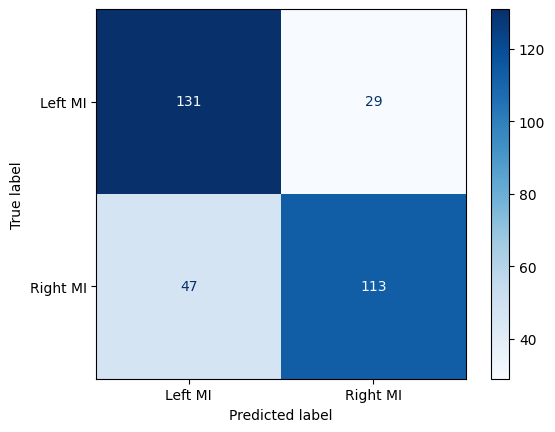

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay

labels = ["Left MI", "Right MI"]

disp = ConfusionMatrixDisplay(confusion_matrix=matriz_confusion, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()

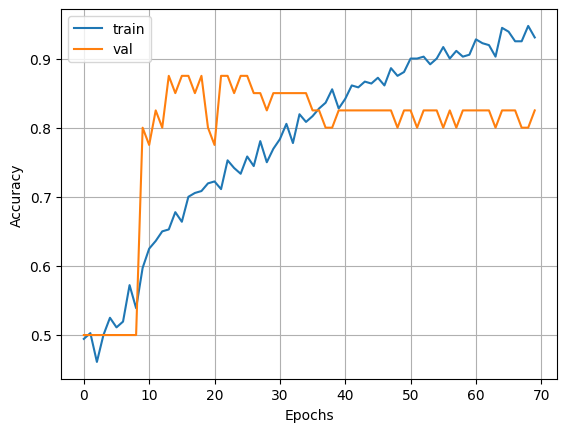

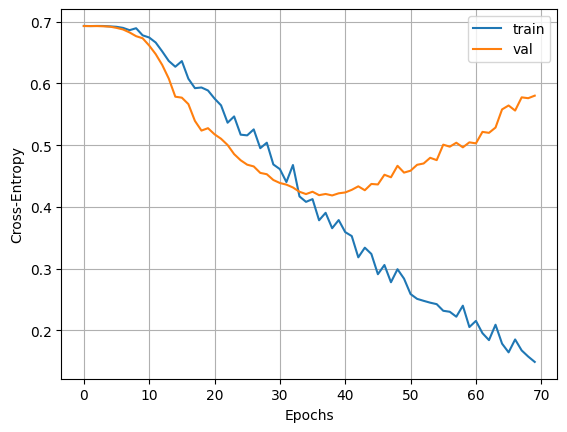


Resultados:
loss: [0.4759801924228668, 0.5286314487457275, 0.572801411151886, 0.44937771558761597, 0.5150427222251892]
accuracy: [0.7906249761581421, 0.8187500238418579, 0.78125, 0.8125, 0.762499988079071]
kappa: [0.525]
time_elapsed: 175.45693397521973


In [20]:
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'val'])
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Cross-Entropy')
  plt.legend(['train', 'val'])
  plt.show()

print()
print("Resultados:")
print("loss:", array_loss)
print("accuracy:", array_acc)
print("kappa:", array_kappa)
fin = time.time()
time_elapsed = fin - initial
print("time_elapsed:", time_elapsed)

In [21]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 135, 31, 4)          │              40 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 67, 15, 4)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 67, 15, 4)           │             148 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 33, 7, 4)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 924)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │          29,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 89,564 (349.86 KB)

 Trainable params: 29,854 (116.62 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 59,710 (233.25 KB)

In [22]:
print("Mean Accuracy: %.4f" % np.mean(array_acc))
print("std: (+/- %.4f)" % np.std(array_acc))
print("Mean Kappa: %.4f" % np.mean(array_kappa))
print("std: (+/- %.4f)" % np.std(array_kappa))
print("Max Accuracy: %.4f" % np.max(array_acc))
print("Max Kappa: %.4f" % np.max(array_kappa))
print("time_elapsed:", int(time_elapsed))

Mean Accuracy: 0.7931
std: (+/- 0.0206)
Mean Kappa: 0.5250
std: (+/- 0.0000)
Max Accuracy: 0.8188
Max Kappa: 0.5250
time_elapsed: 175
